In [125]:
import sys
sys.path.insert(0, "..")

In [128]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cobra
from molmass import Formula
from cobra.io import read_sbml_model
from experiments.fast_dFBA import setup_drawdown, MichaelisMentenBounds, dFBA
from utils.cobra_utils import get_or_create_exchange
from utils.utils import pp
from parameters.drawdown import *
from plotting.diagnostic import uptakes_and_secretions, plot_pathway, plot_metabolite_fluxes

ImportError: cannot import name 'plot_pathway' from 'plotting.diagnostic' (/mnt/c/Users/micha/OneDrive/SchoolWork/Stanford Grad/Projects/Covert Lab/Oceans/rpom-fba/notebooks/../plotting/diagnostic.py)

In [ ]:
MODEL_FILE = "../model/Rpom_05.xml"
BIOMASS_ID = "RPOM_provisional_biomass"
DATA_FILE = "../data/clean/CUE/cue_data.csv"

# Load data
data = pd.read_csv(DATA_FILE)

# Load and set up model
model = read_sbml_model(MODEL_FILE)
setup_drawdown(model)

# Set up Michaelis-Menten medium
ex_glc = model.reactions.get_by_id("EX_glc")
ex_ace = get_or_create_exchange(model, "ACET[e]")

# Get V_maxes
V_max_glc = 10 * abs(float(ex_glc._annotation["Experimental rate"]))
V_max_ace = 10 * abs(float(ex_ace._annotation["Experimental rate"]))

dynamic_medium = {
    ex_glc: MichaelisMentenBounds("Glucose[e]", V_max_glc, K_M.to("mM").magnitude),
    ex_ace: MichaelisMentenBounds(
        "ACET[e]", V_max_ace, K_M.to("mM").magnitude)
}

# Initial state
initial_conditions = data[["Initial_mM_Glucose",
                            "Initial_mM_Acetate"]].drop_duplicates().values

In [ ]:
initial_glucose, initial_acetate = initial_conditions[3, :]

initial_biomass = (data[(data["Type"] == "counts") &
                        (data["Time (h)"] == 0) &
                        (data["Initial_mM_Glucose"] == initial_glucose) &
                        (data["Initial_mM_Acetate"] == initial_acetate)
                        ]["Value"].mean() * (1/u.mL) * MASS_PER_CELL).to("g/L").magnitude
tmax = (data[(data["Type"] == "counts") & (data["Initial_mM_Glucose"] == initial_glucose) & (
    data["Initial_mM_Acetate"] == initial_acetate)]["Time (h)"].max())

substrates = {
    "Glucose[e]" : initial_glucose,
    "ACET[e]": initial_acetate
}

with model:
    for exchange, bounds in dynamic_medium.items():
        bounds.bound(exchange, substrates[bounds.substrate_id])

    # Using lexicographic optimization,
    # first optimize for biomass, then for the exchange fluxes
    # (holding optimal biomass as a constraint),
    # thus guaranteeing a unique optimal set of exchange fluxes.
    lex_constraints = cobra.util.add_lexicographic_constraints(
        model, [BIOMASS_ID, "EX_glc", ex_ace.id], ['max', "max", "max"])
    fluxes = lex_constraints.values

fluxes *= initial_biomass
fluxes

array([ 0.00069602, -0.00720359,  0.        ])

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:title={'center':'2.0 mM Glucose, 0.0 mM Acetate'}, ylabel='flux (mg / hr)'>)

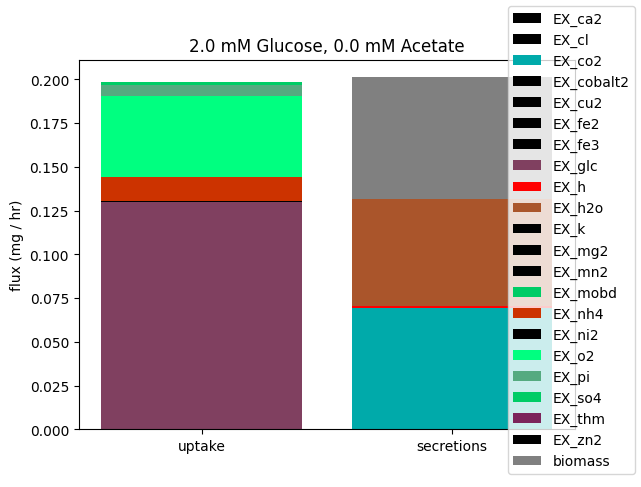

In [ ]:
with model:
    for exchange, bounds in dynamic_medium.items():
        bounds.bound(exchange, substrates[bounds.substrate_id])
    sol = model.optimize()

boundary_ids = [rxn.id for rxn in model.boundary]
boundary_fluxes = sol.fluxes[boundary_ids].reset_index()
boundary_fluxes["fluxes"] = boundary_fluxes["fluxes"] * initial_biomass * CUE_VOLUME.to("L").magnitude  # convert to mmol/hr
boundary_fluxes["Secreting"] = ((np.array([bool(rxn.reactants) for rxn in model.boundary]) & (boundary_fluxes["fluxes"] > 0))
                                | (np.array([bool(rxn.products) for rxn in model.boundary]) & (boundary_fluxes["fluxes"] < 0)))
boundary_fluxes["Mol mass"] = [Formula(list(rxn.metabolites.keys())[0].formula).mass for rxn in model.boundary]

uptakes_and_secretions(model, boundary_fluxes, sol, initial_biomass, CUE_VOLUME, initial_glucose, initial_acetate)

In [ ]:
from cobra.flux_analysis.reaction import assess
with model:
    for exchange, bounds in dynamic_medium.items():
        bounds.bound(exchange, substrates[bounds.substrate_id])
    
    assessment = assess(model, "RPOM_provisional_biomass")
    if assessment != True:
        print(pp(assessment))
    else:
        print("Passed")

Passed


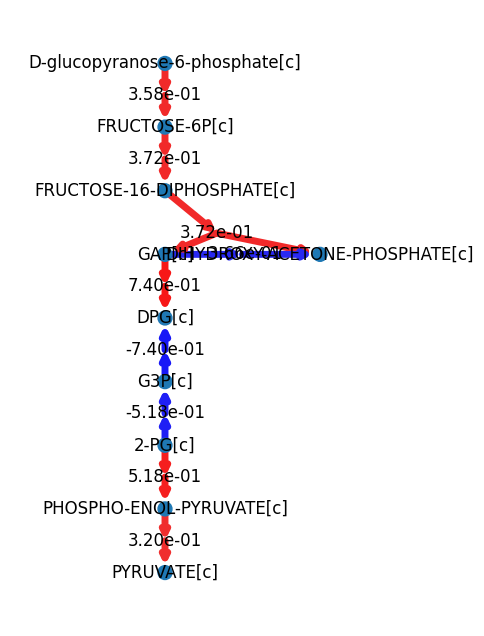

In [ ]:
glycolysis = nx.DiGraph()

# Metabolites
glycolysis.add_nodes_from([
    ("D-glucopyranose-6-phosphate[c]", {"pos": (0, 0)}),
    ("FRUCTOSE-6P[c]", {"pos": (0, -10)}),
    ("FRUCTOSE-16-DIPHOSPHATE[c]", {"pos": (0, -20)}),
    ("GAP[c]", {"pos": (0, -30)}),
    ("DIHYDROXY-ACETONE-PHOSPHATE[c]", {"pos": (10, -30)}),
    ("DPG[c]", {"pos": (0, -40)}),
    ("G3P[c]", {"pos": (0, -50)}),
    ("2-PG[c]", {"pos": (0, -60)}),
    ("PHOSPHO-ENOL-PYRUVATE[c]", {"pos": (0, -70)}),
    ("PYRUVATE[c]", {"pos": (0, -80)}),
])

# Reactions
glyc_reactions = ["PGLUCISOM-RXN",
                  "6PFRUCTPHOS-RXN",
                  "F16ALDOLASE-RXN",
                  "TRIOSEPISOMERIZATION-RXN",
                  "GAPOXNPHOSPHN-RXN",
                  "PHOSGLYPHOS-RXN",
                  "3PGAREARR-RXN",
                  "2PGADEHYDRAT-RXN",
                  "PEPDEPHOS-RXN"]

fig, ax = plt.subplots()
plot_pathway(model, glycolysis, glyc_reactions, ax)
ax.set_xlim([-10, 20])
fig.set_size_inches(6,8)

In [ ]:
sp = sol.shadow_prices.reset_index()
sp["abs(shadow_price)"] = sp["shadow_prices"].abs()
sp = sp.sort_values("abs(shadow_price)", ascending=False)

lines=100
for i, (_, row) in enumerate(sp.iterrows()):
    if i > lines:
        break
    print(f"{row['index'].ljust(40)}\t{str(row['shadow_prices']).rjust(20)}")

KDO2-LIPID-A[c]                         	 -2.1785771023943448
C6[c]                                   	 -2.0313448589373757
KDO2-LIPID-IVA-COLD[c]                  	 -2.0198423399178824
C5[c]                                   	 -1.8921643787949702
KDO2-LAUROYL-LIPID-IVA[c]               	 -1.8427035470093664
KDO2-PALMITOLEOYL-LIPID-IVA[c]          	  -1.683968784532904
KDO2-LIPID-IVA[c]                       	 -1.5574410753125356
KDO2-LIPID-IVA[p]                       	 -1.5574410753125356
KDO-LIPID-IVA[c]                        	 -1.5528400677045224
LIPID-IV-A[c]                           	  -1.548239060096509
BISOHMYR-GLC[c]                         	 -1.5436380524884956
CPD0-2283[p]                            	 -1.4263123584841573
CPD0-2278[p]                            	 -1.3791520305020197
CPD-9646[c]                             	  -1.320489183499304
UNDECAPRENYL-DIPHOSPHATE[c]             	 -1.3193389315973005
CPD-7695[c]                             	 -1.3101369163812737
C4[c]   

In [ ]:
sp[sp["shadow_prices"] > 0].sort_values("abs(shadow_price)")

,index,shadow_prices,abs(shadow_price)
353,PROTON[p],4.510281e-17,4.510281e-17
245,CPD-3[c],2.910383e-11,2.910383e-11
246,CPD-3[p],2.910383e-11,2.910383e-11
615,GLUTAMATE-1-SEMIALDEHYDE[c],5.751260e-04,5.751260e-04
223,5-AMINO-LEVULINATE[c],5.751260e-04,5.751260e-04
...,...,...,...
1349,R-3-hydroxy-cis-vaccenoyl-ACPs[c],5.820275e-01,5.820275e-01
1348,3-oxo-cis-vaccenoyl-ACPs[c],5.889290e-01,5.889290e-01
1157,CPD-18353[c],8.350829e-01,8.350829e-01
1593,CPD-12258[p],1.169806e+00,1.169806e+00


(-50.0, 20.0)

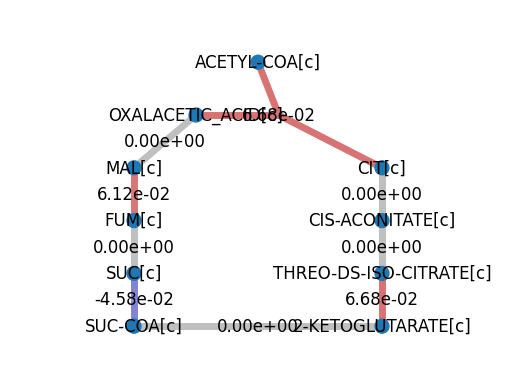

In [ ]:
tca = nx.Graph()

# Metabolites
tca.add_nodes_from([
    ("ACETYL-COA[c]", {"pos": (0, 10)}),
    ("CIT[c]", {"pos": (10, -10)}),
    ("CIS-ACONITATE[c]", {"pos": (10, -20)}),
    ("THREO-DS-ISO-CITRATE[c]", {"pos": (10, -30)}),
    ("2-KETOGLUTARATE[c]", {"pos": (10, -40)}),
    ("SUC-COA[c]", {"pos": (-10, -40)}),
    ("SUC[c]", {"pos": (-10, -30)}),
    ("FUM[c]", {"pos": (-10, -20)}),
    ("MAL[c]", {"pos": (-10, -10)}),
    ("OXALACETIC_ACID[c]", {"pos": (-5, 0)}),
])

# Reactions
tca_reactions = ["CITSYN-RXN",
                  "ACONITATEDEHYDR-RXN",
                  "ACONITATEHYDR-RXN",
                  "ISOCITDEH-RXN",
                  "2OXOGLUTARATEDEH-RXN",
                  "SUCCCOASYN-RXN",
                  "RXN-14970-SUC/UBIQUINONE-8//FUM/CPD-9956.31.",
                  "FUMHYDR-RXN",
                  "MALATE-DEH-RXN"]

fig, ax = plt.subplots()
plot_pathway(model, tca, tca_reactions, ax)
ax.set_xlim([-20, 20])
ax.set_ylim([-50, 20])

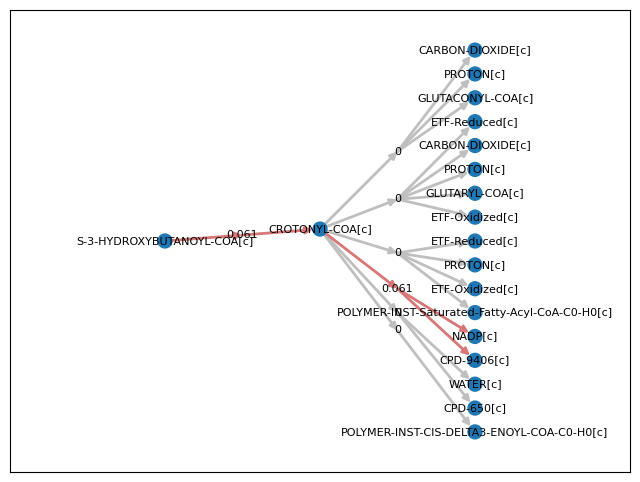

In [ ]:
fig, ax = plt.subplots()
g, _ = plot_metabolite_fluxes(model, "CROTONYL-COA[c]", ax=ax)
ax.set_xlim(-40, 40)
fig.set_size_inches(8, 6)

(-20.0, 20.0)

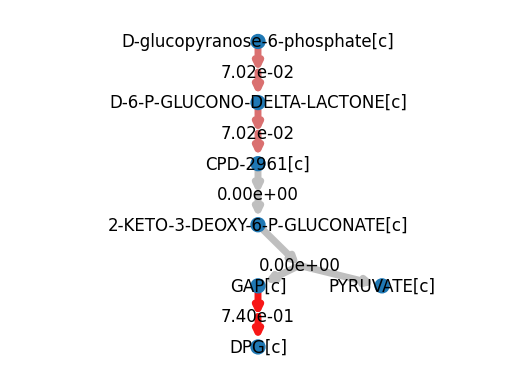

In [ ]:
ed = nx.DiGraph()

# Metabolites
ed.add_nodes_from([
    ("D-glucopyranose-6-phosphate[c]", {"pos": (0, 0)}),
    ("D-6-P-GLUCONO-DELTA-LACTONE[c]", {"pos": (0, -10)}),
    ("CPD-2961[c]", {"pos": (0, -20)}),
    ("2-KETO-3-DEOXY-6-P-GLUCONATE[c]", {"pos": (0, -30)}),
    ("GAP[c]", {"pos": (0, -40)}),
    ("PYRUVATE[c]", {"pos": (10, -40)}),
    ("DPG[c]", {"pos": (0, -50)})
])

# Reactions
ed_reactions = ["GLU6PDEHYDROG-RXN",
                  "6PGLUCONOLACT-RXN",
                  "PGLUCONDEHYDRAT-RXN",
                  "KDPGALDOL-RXN",
                  "GAPOXNPHOSPHN-RXN",
                  ]

fig, ax = plt.subplots()
plot_pathway(model, ed, ed_reactions, ax)
ax.set_xlim([-20, 20])

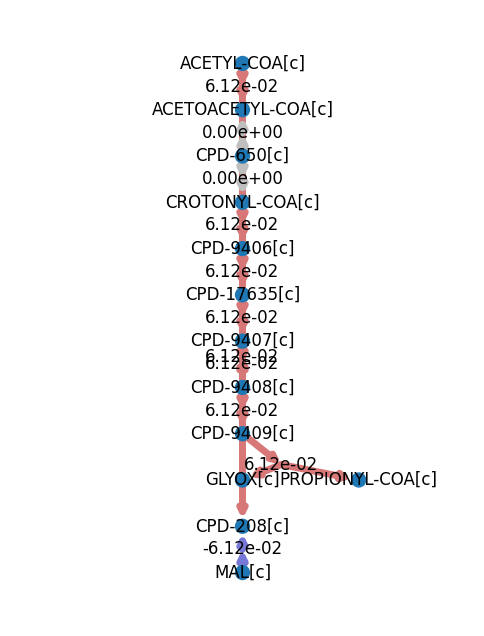

In [ ]:
emcoa = nx.DiGraph()

# Metabolites
emcoa.add_nodes_from([
    ("ACETYL-COA[c]", {"pos": (0, 0)}),
    # ("CO-A[c]", {"pos": (10, -10)}),
    ("ACETOACETYL-COA[c]", {"pos": (0, -10)}),
    ("CPD-650[c]", {"pos": (0, -20)}),
    ("CROTONYL-COA[c]", {"pos": (0, -30)}),
    ("CPD-9406[c]", {"pos": (0, -40)}),
    ("CPD-17635[c]", {"pos": (0, -50)}),
    ("CPD-9407[c]", {"pos": (0, -60)}),
    ("CPD-9408[c]", {"pos": (0, -70)}),
    ("CPD-9409[c]", {"pos": (0, -80)}),
    ("PROPIONYL-COA[c]", {"pos": (10, -90)}),
    ("GLYOX[c]", {"pos": (0, -90)}),
    ("CPD-208[c]", {"pos": (0, -100)}),
    ("MAL[c]", {"pos": (0, -110)})
])

# Reactions
emcoa_reactions = ["ACETYL-COA-ACETYLTRANSFER-RXN",
                  "RXN-5901",
                  "3-HYDROXBUTYRYL-COA-DEHYDRATASE-RXN",
                  "RXN-8957",
                  "RXN-16391",
                  "RXN-8958",
                  "RXN-8959",
                  "RXN-8960",
                  "RXN-8961",
                  "MALYL-COA-LYASE-RXN",
                  "MALATE--COA-LIGASE-RXN"
                  ]

fig, ax = plt.subplots()
plot_pathway(model, emcoa, emcoa_reactions, ax)
ax.set_xlim([-20, 20])
fig.set_size_inches(6,8)

(-20.0, 20.0)

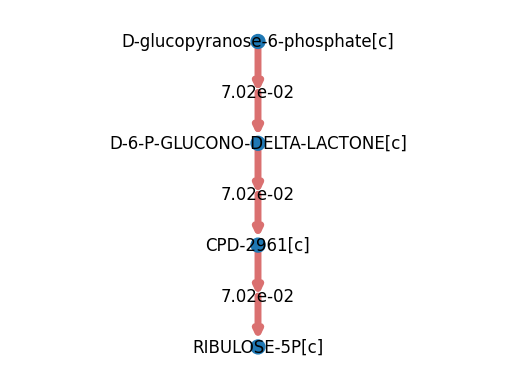

In [ ]:
penp = nx.DiGraph()

# Metabolites
penp.add_nodes_from([
    ("D-glucopyranose-6-phosphate[c]", {"pos": (0, 0)}),
    ("D-6-P-GLUCONO-DELTA-LACTONE[c]", {"pos": (0, -10)}),
    ("CPD-2961[c]", {"pos": (0, -20)}),
    ("RIBULOSE-5P[c]", {"pos": (0, -30)})
])

# Reactions
penp_reactions = ["GLU6PDEHYDROG-RXN",
                  "6PGLUCONOLACT-RXN",
                  "RXN-9952"]

fig, ax = plt.subplots()
plot_pathway(model, penp, penp_reactions, ax)
ax.set_xlim([-20, 20])

In [ ]:
phb = model.metabolites.get_by_id("PHB-MONOMER[c]")
mmass = 85.0813  # g / mol

with model:
    for exchange, bounds in dynamic_medium.items():
        bounds.bound(exchange, substrates[bounds.substrate_id])
    
    biomass_rxn = model.reactions.get_by_id("RPOM_provisional_biomass")
    biomass_rxn.add_metabolites({
        phb: -0.09 * mmass * 1e-3
    })
    
    sol = model.optimize()

sol

,fluxes,reduced_costs
1-ACYLGLYCEROL-3-P-ACYLTRANSFER-RXN,0.003113,0.000000e+00
1.1.1.178-RXN,0.000000,-2.759098e-02
1.1.1.262-RXN,0.000000,0.000000e+00
1.1.1.39-RXN,0.000000,-9.196993e-03
1.1.1.8-RXN,0.000000,0.000000e+00
...,...,...
RXN0-1134,0.363920,0.000000e+00
RXN0-1133,0.363920,0.000000e+00
RXN0-1132,0.363920,5.551115e-17
CYTOCHROME-C-OXIDASE-RXN,0.868669,0.000000e+00


In [ ]:
model.metabolites.get_by_id("PHB-MONOMER[c]")

Metabolite identifier,PHB-MONOMER[c]
Name,PHB monomer ((3R)-3-hydroxybutanoyl)
Memory address,0x7f68c523aef0
Formula,C4H5O2
Compartment,c
In 3 reaction(s),"BiomassRxn, PHB-SYNTHESIS, PHB-DEGRADATION"
